In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

2024-03-02 18:00:37.454656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
R, L, C, A, PHI = 1/30, 1/15, 5, 2, 3
K = dde.Variable(1.0)

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)

    return dy_xx + (R / L) * dy_x + K * y - A * tf.cos(PHI * x[:, 0:1])

def y_real(X):
    x = X[0]
    t1 = (19 / (51 * np.sqrt(47))) * np.sin(np.sqrt(47) * x / 4)
    t2 = 67 * np.cos(np.sqrt(47) * x / 4) / 51
    t3 = np.exp(x / 4)
    t4 = (4 / 51) * np.sin(3 * x)
    t5 = (16 / 51) * np.cos(3 * x)
    return ((t1 + t2) / t3) + t4 - t5

def func(x):
    t1 = (19 / (51 * np.sqrt(47))) * np.sin(np.sqrt(47) * x[:, 0:1] / 4)
    t2 = 67 * np.cos(np.sqrt(47) * x[:, 0:1] / 4) / 51
    t3 = np.exp(x[:, 0:1] / 4)
    t4 = (4 / 51) * np.sin(3 * x[:, 0:1])
    t5 = (16 / 51) * np.cos(3 * x[:, 0:1])
    return ((t1 + t2) / t3) + t4 - t5

In [3]:
geom = dde.geometry.TimeDomain(0, 5)

bc = dde.icbc.NeumannBC(geom, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geom, lambda x: 1, lambda _, on_initial: on_initial)

observe_x = np.reshape(np.arange(0, 5, 0.25), (-1, 1))
noise = np.random.normal(0, 0.1, (len(observe_x, )))
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x) + noise, component=0)

data = dde.data.PDE(
    geom,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=1,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

In [4]:
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=K)

variable = dde.callbacks.VariableValue(K, period=1000, filename="variable.dat")
loss_history, train_state = model.train(iterations=25000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.060335 s



/usr/local/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.431698 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.11e+00, 6.18e-02, 1.00e+00, 7.22e-01]    [2.13e+00, 6.18e-02, 1.00e+00, 7.22e-01]    [1.37e+00]    
1000      [4.59e-02, 6.74e-03, 1.11e-03, 7.74e-02]    [4.33e-02, 6.74e-03, 1.11e-03, 7.74e-02]    [4.18e-01]    
2000      [9.81e-03, 2.29e-03, 1.43e-04, 2.82e-02]    [1.01e-02, 2.29e-03, 1.43e-04, 2.82e-02]    [2.01e-01]    
3000      [1.11e-03, 2.27e-04, 2.37e-08, 1.39e-02]    [1.05e-03, 2.27e-04, 2.37e-08, 1.39e-02]    [3.24e-02]    
4000      [3.84e-04, 3.03e-05, 2.83e-06, 1.36e-02]    [3.11e-04, 3.03e-05, 2.83e-06, 1.36e-02]    [5.01e-03]    
5000      [3.92e-04, 2.96e-05, 2.39e-06, 1.35e-02]    [3.25e-04, 2.96e-05, 2.39e-06, 1.35e-02]    [7.93e-03]    
6000      [1.81e-04, 3.23e-05, 4.14e-06, 1.36e-02]    [1.49e-04, 3.23e-05, 4.14e-06, 1.36e-02]    [5.12e-03]    
7000      [1.80e-04, 2.59e-05, 3.24e-06, 1.36e-02]

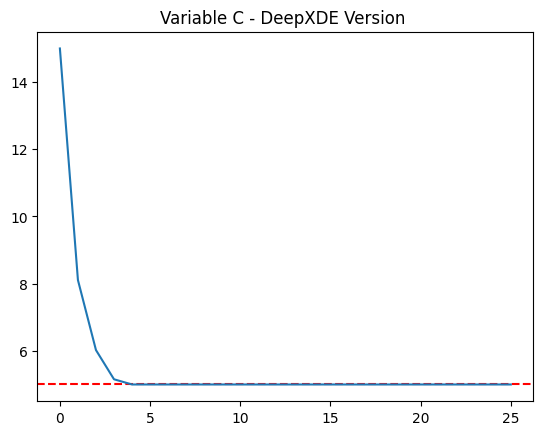

In [5]:
from matplotlib import pyplot as plt

history_k = 1 / (L * np.array([float(i.strip().split()[1][1:-1]) for i in open("variable.dat").readlines()]))
plt.axhline(y=C, c="r", linestyle="dashed")
plt.title("Variable C - DeepXDE Version ")
plt.plot(history_k);

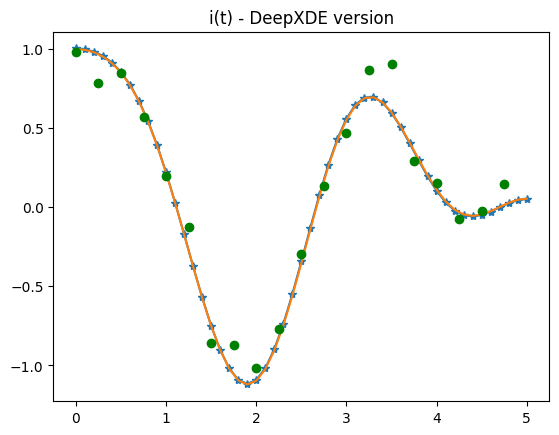

In [6]:
plt.title("i(t) - DeepXDE version")
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [model.predict(np.array([[x]]))[0] for x in np.arange(0, 5.1, 0.1)], marker="*", zorder=0)
plt.plot([x for x in np.arange(0, 5.1, 0.1)], [y_real([x]) for x in np.arange(0, 5.1, 0.1)], zorder=1)
plt.scatter([x[0] for x in observe_x], [y_real(x) + noise[i] for i, x in enumerate(observe_x)], c="g", zorder=3);

In [7]:
print(f"Capacity real = {C}, capacity from the PINN = {np.round(np.float64(history_k[-1]), 2)}")

Capacity real = 5, capacity from the PINN = 5.0
